In [1]:
from src.array import Array
from src.matrix import Matrix
from src.equation import Equation
from src.failure import Failure

In [2]:
length = 3
width = 2.0
seed = 0

In [3]:
array = Array(length=length, mode_analysis=True)
matrix = Matrix(matrix_init=None, array=array)
equation = Equation(array=array, matrix=matrix)
failure = Failure(array=array, matrix=matrix, equation=equation, width=width, seed=seed, save_volts_profile=True)

solve = equation.solve_mmd
break_edge = failure.break_edge_init
solve()
break_edge()

break_edge = failure.break_edge
for _ in range(array.length - 1):
    solve()
    break_edge()

solve = equation.solve_amd
while solve():
    break_edge()

In [4]:
from pathlib import Path
import numpy as np

In [5]:
records= []

In [ ]:
for length in range(10, 50, 10):
    array = Array(length=length, mode_analysis=True)
    matrix_init = Matrix(matrix_init=None, array=array)
    for width in np.arange(0.25, 2.25, 0.25).tolist() + [0.85, 1.15]:
        for seed in list(range(100)) + list(range(800, 1000)) + [666, 111, 847, 223, 844]:
            matrix = Matrix(matrix_init=matrix_init, array=None)
            equation = Equation(array=array, matrix=matrix)
            failure = Failure(array=array, matrix=matrix, equation=equation, width=width, seed=seed, save_volts_profile=True)

            solve = equation.solve_mmd
            break_edge = failure.break_edge_init
            solve()
            break_edge()

            break_edge = failure.break_edge
            for _ in range(array.length - 1):
                solve()
                break_edge()

            solve = equation.solve_amd
            while solve():
                break_edge()

            path_seed = Path.cwd() / "data" / str(array.length) / str(failure.width) / str(failure.seed)

            asdf = np.load(path_seed / "volts_ext.npy")
            if len(failure.volts_ext) != len(asdf):
                records.append((-1, length, width, seed))
            if (np.array(failure.volts_ext) - asdf).sum() + (np.array(failure.idxs_edge_broken) - np.load(path_seed / "idxs_edge_broken.npy")).sum() != 0:
                records.append((1, length, width, seed))
        print((length, width), len(records))

(10, 0.25) 0
(10, 0.5) 0
(10, 0.75) 0
(10, 1.0) 0
(10, 1.25) 0
(10, 1.5) 0
(10, 1.75) 0
(10, 2.0) 0
(10, 0.85) 0
(10, 1.15) 0
(20, 0.25) 0
(20, 0.5) 0
(20, 0.75) 0
(20, 1.0) 0
(20, 1.25) 0
(20, 1.5) 0
(20, 1.75) 0
(20, 2.0) 0
(20, 0.85) 0
(20, 1.15) 0
(30, 0.25) 0
(30, 0.5) 0
(30, 0.75) 0
(30, 1.0) 0
(30, 1.25) 0


In [ ]:
records

[(-1, 10, 0.25, 0)]

In [ ]:
(np.array(failure.idxs_edge_broken) - np.load(path_seed / "idxs_edge_broken.npy"))

ValueError: operands could not be broadcast together with shapes (18,) (10,) 

np.float64(0.0)

In [ ]:
asdf

NameError: name 'asdf' is not defined

---
---
---

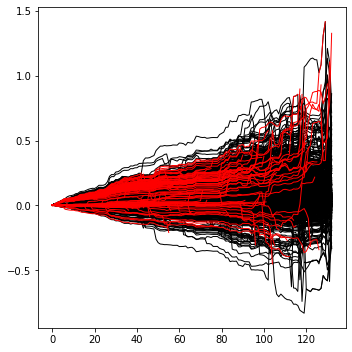

In [ ]:
from src_tbc.draw_new import draw_volts_edge_profile
draw_volts_edge_profile(array, failure, 1)

---
---
---

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from src_tbc.draw import Draw


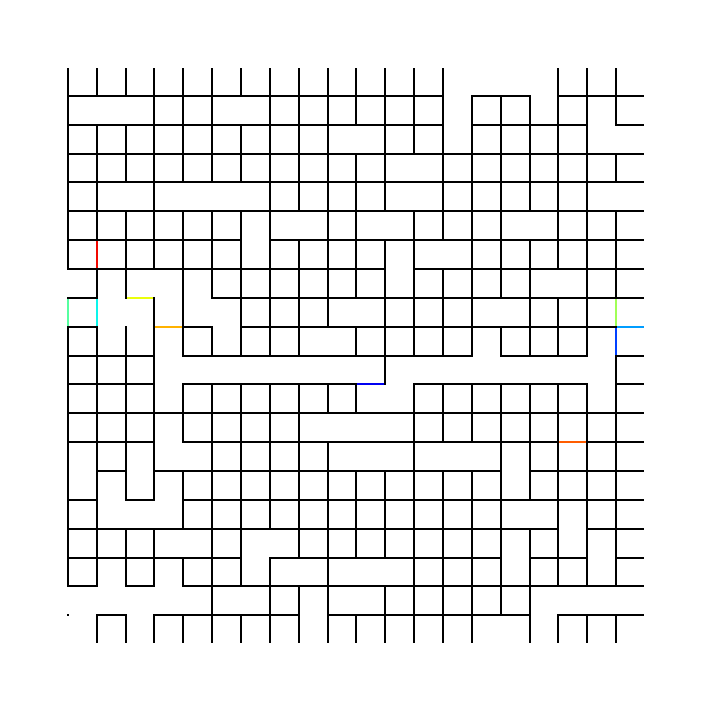

In [ ]:
draw = Draw(array=array, matrix=matrix, equation=equation, failure=failure)
draw.graph_initialize(
    figsize=(10, 10), dpi=72, size_edge=2, pad_inches=-0.7, transparent=False,
    save=False, show=True,
)

draw.graph_specific(failure.idxs_edge_broken, 10)
# draw.graph_breakdown_images()
# draw.graph_breakdown_video()

In [ ]:
#
length, length_minus_one, length_plus_one = array.length, array.length - 1, array.length + 1
num_face = array.length ** 2
faces = list(range(num_face))

#
faces_to_nodes, faces_to_edges = [None] * num_face, [None] * num_face

for face in faces:
    nodes = [face, face + length]

    if (face + 1) % array.length == 0: # face which contains 2 "periodic" nodes
        nodes.append(face + 1)
        nodes.append(face - length_minus_one)
    else:
        nodes.append(face + length_plus_one)
        nodes.append(face + 1)
    faces_to_nodes[face] = nodes
    
    faces_to_edges[face] = [
        (nodes[0], nodes[1]), 
        (nodes[1], nodes[2]) if nodes[1] < nodes[2] else (nodes[2], nodes[1]) ,
        (nodes[3], nodes[2]), 
        (nodes[0], nodes[3]) if nodes[0] < nodes[3] else (nodes[0], nodes[3]),
    ]

#
dict_edge_to_idx_edge = {edge: idx_edge for idx_edge, edge in enumerate(array.edges)}
dict_edge_to_idx_edge

#
faces_to_idxs_edge = [None] * num_face
for face, edges in enumerate(faces_to_edges):
    idxs_edge = []
    for edge in edges:
        try:
            idxs_edge.append(dict_edge_to_idx_edge[edge])
        except:
            idxs_edge.append(None)
        
        faces_to_idxs_edge[face] = idxs_edge

#
idxs_edge_to_edges_dual = [None] * array.num_edge
idxs_edge_to_edges_dual_pseudo = [None] * array.num_edge
for idx_edge, edge in enumerate(array.edges):
    idx_node1, idx_node2 = edge # idx_node1 < idx_node2

    # vertical
    if idx_node2 == idx_node1 + length:

        if idx_node1 % length == 0: # EDGE_DUAL AFFECTED BY PBC PERIODICITY
            idx_face1 = idx_node1
            idx_face2 = idx_node2 - 1

            idx_face1_pseudo = - idx_node1 // length - 1
        else:
            idx_face1 = idx_node1 - 1
            idx_face2 = idx_node1

            idx_face1_pseudo = idx_node1 - 1
        
    # horizontal
    else:
        if idx_node1 % length == 0 and idx_node2 % length == length_minus_one: # EDGE_DUAL AFFECTED BY PBC PERIODICITY
            idx_face1 = idx_node1 - 1
            idx_face2 = idx_node2

            idx_face1_pseudo = idx_node1 - 1
        else:
            idx_face1 = idx_node1 - length
            idx_face2 = idx_node1

            idx_face1_pseudo = idx_node1 - length

    idxs_edge_to_edges_dual[idx_edge] = (idx_face1, idx_face2) # must be sorted tuple int pairs
    idxs_edge_to_edges_dual_pseudo[idx_edge] = (idx_face1_pseudo, idx_face2)

# sanity check
(
    all([xd == (xd[0], xd[1]) if xd[0] < xd[1] else (xd[1], xd[0]) for xd in idxs_edge_to_edges_dual]),
    all([xd == (xd[0], xd[1]) if xd[0] < xd[1] else (xd[1], xd[0]) for xd in idxs_edge_to_edges_dual_pseudo])
)


(True, True)

In [ ]:
colors_edge = draw.colors_edge.astype(np.float16)
colors_edge[failure.idxs_edge_broken] = np.ones(3, dtype=np.int8)
colors_edge = np.vstack([colors_edge[draw.idxs_edge_pbc][::-1], np.delete(colors_edge, draw.idxs_edge_pbc, axis=0)])

In [ ]:
faces_pos_x, faces_pos_y = np.meshgrid(np.arange(length) + 0.5, np.arange(length, 0, -1) - 0.5)
faces_pos_x, faces_pos_y = faces_pos_x.reshape(-1), faces_pos_y.reshape(-1)
faces_pos = {idx_face: (float(face_pos_x), float(face_pos_y)) for idx_face, (face_pos_x, face_pos_y) in enumerate(zip(faces_pos_x, faces_pos_y))}

In [ ]:
faces_pos_pseudo = {(-length + i): (length + 0.5, i + 0.5)  for i in range(length)} | faces_pos

In [ ]:
edges_dual = np.array(idxs_edge_to_edges_dual)[failure.idxs_edge_broken].tolist() # NOT FOR PLOTTING
graph_dual = nx.Graph()
graph_dual.add_edges_from(edges_dual)

edges_dual_pseudo = np.array(idxs_edge_to_edges_dual_pseudo)[failure.idxs_edge_broken].tolist() # FOR 2D PLOTTING PBC PERIODICITY COVERED
graph_dual_pseudo = nx.Graph()
graph_dual_pseudo.add_edges_from(edges_dual_pseudo)

<BarContainer object of 7 artists>

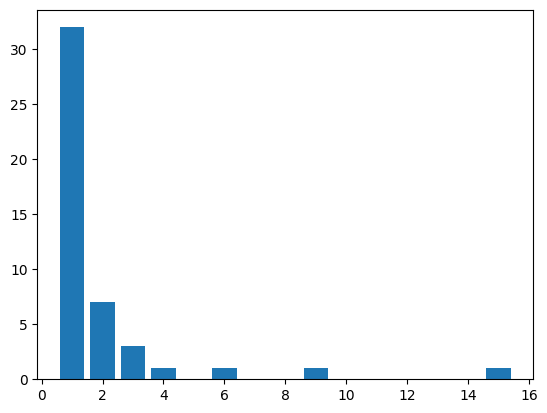

In [ ]:
cracks = list(nx.connected_components(graph_dual))
diameters = [nx.diameter(graph_dual.subgraph(crack_nodes)) for crack_nodes in cracks]
diameters_unique, counts_unique = np.unique(diameters, return_counts=True)
plt.bar(diameters_unique, counts_unique)

In [ ]:
# method 1
cracks = list(nx.connected_components(graph_dual))

count_cycle = 0
for crack_nodes in cracks:
    subgraph = graph_dual.subgraph(crack_nodes)
    try:
        cycle = nx.find_cycle(subgraph)
        count_cycle += 1
        # break
    except nx.exception.NetworkXNoCycle:
        continue
# else:
#     raise RuntimeError("no cycle")

# # method 2
# cycle = nx.find_cycle(graph_dual)

cycle = [(c1, c2) if c1 < c2 else (c2, c1) for c1, c2 in cycle]
cycle_pseudo = [(-(idx_face2 + 1) // length, idx_face2) if (idx_face2 - idx_face1 == length_minus_one) else (idx_face1, idx_face2) for idx_face1, idx_face2 in cycle]

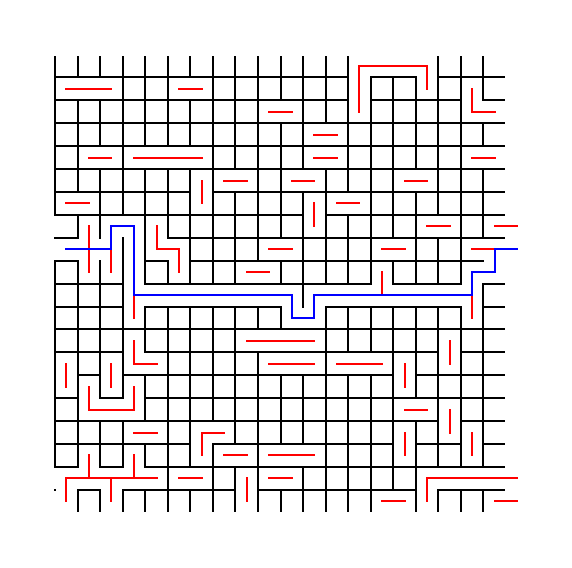

In [ ]:
subgraph_dual_pseudo = nx.Graph()
subgraph_dual_pseudo.add_edges_from(cycle_pseudo)

subgraph_dual_pseudo_pos = {}
for key, val in faces_pos_pseudo.items():
    if key in subgraph_dual_pseudo.nodes:
        subgraph_dual_pseudo_pos[key] = val

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=draw.dpi)
nx.draw(
    draw.graph, ax=ax, 
    pos=draw.pos,
    node_shape="s", node_color=draw.colors_node, edgecolors="none", edge_color=colors_edge, 
    node_size=draw.size_edge ** 2, width=draw.size_edge,
    # with_labels=True, font_color="black", font_size=10,
)

nx.draw(
    graph_dual_pseudo, ax=ax,
    pos=faces_pos_pseudo,
    node_shape="s", node_color="red", edgecolors="none", edge_color="red", 
    node_size=draw.size_edge ** 2, width=draw.size_edge,
    # with_labels=True, font_color="red", font_size=10,
)

nx.draw(
    subgraph_dual_pseudo, ax=ax,
    pos=subgraph_dual_pseudo_pos,
    node_shape="s", node_color="blue", edgecolors="none", edge_color="blue", 
    node_size=draw.size_edge ** 2, width=draw.size_edge,
)
